# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020

Mark Bauer

# Goal
In this notebook, we analyze NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to answer the following questions:

- What is the distribution of street flooding complaints by neighborhood?
- How have street flooding complaints changed over time?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

[geoplot](https://residentmario.github.io/geoplot/index.html#) is a high-level Python geospatial plotting library. It’s an extension to cartopy and matplotlib which makes mapping easy: like seaborn for geospatial.

[fiona](https://github.com/Toblerity/Fiona) is a geospatial library that reads and writes geographical data files.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

Table of Contents
=================

   * [1. Importing Libraries](#1-Importing-Libraries)
       
       
   * [2. Loading Data](#2-Loading-Data)
       
       
   * [3. Data Inspection](#3-Data-Inspection)
       * [3.1 Basic Data Inspection](#31-Basic-Data-Inspection)
       * [3.2 Calculating Summary Statistics](#32-Calculating-Summary-Statistics)
       * [3.3 Identifying Null/NA Values](#33-Identifying-Null/NA-Values)
   
   
   * [4. Data Wrangling](#4-Data-Wrangling)
       * [4.1 Converting date column to Python's datetime64[ns] data type](#41-Converting-date-column-to-Pythons-datetime64[ns]-data-type)
       * [4.2 Dropping null values in our x, y coordinate columns](#42-Dropping-null-values-in-our-x-y-coordinate-columns)
       * [4.3 Creating a GeoDataframe from x,y coordinates](#43-Creating-a-GeoDataframe-from-x-y-coordinates)
       

   * [5. Mapping](#5-Mapping)
       * [5.1 Citywide](#51-Citywide)
       * [5.2 By Borough](#52-By-Borough)
       * [5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)](#53-Bar-Charts-by-Neighborhood-Tabulation-Areas-(NTA))

      
   * [6. Time Series Analysis](#6-Time-Series-Analysis)
       * [6.1 By Year and Borough](#61-By-Year-and-Borough)
       * [6.2 Frequencies](#62-Frequencies)
       * [6.3 Resampling](#63-Resampling)
       * [6.4 Seasonality](#64-Seasonality)
       * [6.5 Resampling for Frequency Average](#65-Resampling-for-Frequency-Average)
       * [6.6 Rolling Averages](66-Rolling-Averages)
       * [6.7 Additional Time Series Analysis](#67-Additional-Time-Series-Analysis)
   
          
   * [7. Anomoly Detection](#7-Anomoly-Detection)
   
          
   * [8. Manually Formatting Date Tick Labels](#8-Manually-Formatting-Date-Tick-Labels)
   
   
   * [9. Timedelta of Complaints](#9-Timedelta-of-Complaints)
   
          
   * [10. Conclusion](#10-Conclusion)

# 1. Importing Libraries

In [50]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [51]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [52]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.20.0

numpy 1.19.2
pandas 1.2.1
geopandas 0.8.1
geoplot 0.4.0
fiona 1.8.13.post1
matplotlib.pyplot 3.3.2
seaborn 0.11.1


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [53]:
# list items in data folder
%ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [54]:
os.listdir('data-raw/')

['raw-streets-clipped.json',
 'raw-street-flooding-data.csv',
 '.ipynb_checkpoints']

In [55]:
# read data as a dataframe
flooding_311 = pd.read_csv('data-raw/raw-street-flooding-data.csv', \
                           low_memory = False)

# previewing first five rows in data
print(flooding_311.shape)
flooding_311.head()

(27868, 38)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,intersection_street_1,intersection_street_2,bbl,location_type,due_date,landmark,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment
0,31862075,2015-10-28T17:44:00.000,2015-10-29T11:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11694.00,BEACH 101 STREET,BEACH 101 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25163797,2013-03-12T12:38:00.000,2013-03-12T14:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,CHURCH LANE,CHURCH LANE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25185984,2013-03-15T12:13:00.000,2013-03-18T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,CHURCH LANE,CHURCH LANE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25187738,2013-03-15T12:20:00.000,2013-03-15T14:22:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,CHURCH LANE,CHURCH LANE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25338491,2013-04-11T12:16:00.000,2013-04-11T12:16:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,CHURCH LANE,CHURCH LANE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# previewing the last five rows of our dataframe
flooding_311.tail()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,intersection_street_1,intersection_street_2,bbl,location_type,due_date,landmark,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment
27863,31087754,2015-07-15T11:54:00.000,2015-07-15T13:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11225.00,99 OCEAN AVENUE,OCEAN AVENUE,...,NaN,NaN,3050240001.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27864,23268850,2012-05-21T15:13:00.000,2012-05-25T14:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10016.00,NaN,NaN,...,E 28 ST,1 AVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27865,23298517,2012-05-25T22:41:00.000,2012-05-29T17:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10454.00,NaN,NaN,...,WILLIS AVE,E 134 ST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27866,31195478,2015-07-30T18:05:00.000,2015-07-30T18:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11433.00,NaN,NaN,...,GUY R BREWER BOULEVARD,109 AVENUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27867,31504023,2015-09-10T08:45:00.000,2015-09-10T13:11:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11691.00,10-95 GIPSON STREET,GIPSON STREET,...,NaN,NaN,4157170078.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Data Inspection

## 3.1 Basic Data Inspection

In [57]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [58]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'bbl', 'location_type', 'due_date', 'landmark',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment'],
      dtype='object')

In [59]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
incident_zip                      float64
incident_address                   object
street_name                        object
cross_street_1                     object
cross_street_2                     object
address_type                       object
city                               object
facility_type                     float64
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
borough                            object
x_coordinate_state_plane          float64
y_coordinate_state_plane          float64
open_data_channel_type             object
park_facility_name                

In [60]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27868 non-null  int64  
 1   created_date                    27868 non-null  object 
 2   closed_date                     27866 non-null  object 
 3   agency                          27868 non-null  object 
 4   agency_name                     27868 non-null  object 
 5   complaint_type                  27868 non-null  object 
 6   descriptor                      27868 non-null  object 
 7   incident_zip                    27011 non-null  float64
 8   incident_address                17835 non-null  object 
 9   street_name                     17835 non-null  object 
 10  cross_street_1                  24114 non-null  object 
 11  cross_street_2                  24103 non-null  object 
 12  address_type                    

In [61]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'bbl', 'location_type', 'due_date', 'landmark',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment'],
      dtype='object')

In [62]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [63]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27868 non-null  int64  
 1   created_date                    27868 non-null  object 
 2   closed_date                     27866 non-null  object 
 3   agency                          27868 non-null  object 
 4   agency_name                     27868 non-null  object 
 5   complaint_type                  27868 non-null  object 
 6   descriptor                      27868 non-null  object 
 7   incident_zip                    27011 non-null  float64
 8   intersection_street_1           10090 non-null  object 
 9   intersection_street_2           10090 non-null  object 
 10  address_type                    27862 non-null  object 
 11  city                            27012 non-null  object 
 12  status                          

In [64]:
# counts of unique values of our datatypes 
flooding_311.dtypes.value_counts()

object     23
float64     6
int64       1
dtype: int64

In [65]:
# printing index type
flooding_311.index

RangeIndex(start=0, stop=27868, step=1)

In [66]:
cols_unique = flooding_311.columns

print('Inpecting data for unique columns (True/False)\n' + \
     ('-' * 46))

for i in cols_unique:
    print(str(i) + ':', flooding_311[i].is_unique)

Inpecting data for unique columns (True/False)
----------------------------------------------
unique_key: True
created_date: False
closed_date: False
agency: False
agency_name: False
complaint_type: False
descriptor: False
incident_zip: False
intersection_street_1: False
intersection_street_2: False
address_type: False
city: False
status: False
resolution_description: False
resolution_action_updated_date: False
community_board: False
borough: False
x_coordinate_state_plane: False
y_coordinate_state_plane: False
open_data_channel_type: False
park_facility_name: False
park_borough: False
latitude: False
longitude: False
location: False
incident_address: False
street_name: False
cross_street_1: False
cross_street_2: False
bbl: False


In [67]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [68]:
# printing descriptive statistics of our numeric columns in our data
all_columns = flooding_311.columns
flooding_311[all_columns].astype(str).describe(include='all')[:2].T.sort_values(by='unique', 
                                                                                ascending=False)

,count,unique
unique_key,27868,27868
created_date,27868,26359
closed_date,27868,25392
resolution_action_updated_date,27868,25381
location,27868,15893
longitude,27868,15810
latitude,27868,15808
x_coordinate_state_plane,27868,15657
y_coordinate_state_plane,27868,15614
incident_address,27868,12428


In [69]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27868
Name: descriptor, dtype: int64

In [70]:
flooding_311['agency'].value_counts()

DEP    27868
Name: agency, dtype: int64

In [71]:
flooding_311['agency_name'].value_counts()

Department of Environmental Protection    27868
Name: agency_name, dtype: int64

In [72]:
flooding_311['complaint_type'].value_counts()

Sewer    27868
Name: complaint_type, dtype: int64

In [73]:
flooding_311['status'].value_counts()

Closed      27862
Pending         4
Started         1
Assigned        1
Name: status, dtype: int64

In [74]:
flooding_311['resolution_description'].value_counts().reset_index().head()

,index,resolution_description
0,The Department of Environment Protection inspe...,11535
1,The Department of Environmental Protection has...,4031
2,The Department of Environmental Protection ins...,3501
3,The Department of Environmental Protection inv...,2914
4,The Department of Environmental Protection ins...,1276


In [75]:
print('Top 10 Resolution Descriptions in Descending Order:\n')

for i in range(10):
    print(str(i + 1) + '.', \
          flooding_311['resolution_description'].value_counts().index[i], \
          '\nCount: ' \
          f"{flooding_311['resolution_description'].value_counts()[i]:,}" + \
          '\n')

Top 10 Resolution Descriptions in Descending Order:

1. The Department of Environment Protection inspected your complaint but could not find the problem you reported. If the condition persists, please call 311 (or 212-639-9675 if calling from a non-New York City area code) with more detailed information to submit a new complaint. 
Count: 11,535

2. The Department of Environmental Protection has determined that this issue was previously reported by another customer The original complaint is being addressed. If the condition persists, please call 311 (or 212-639-9675 if calling from a non-New York City area code) to submit a new complaint. 
Count: 4,031

3. The Department of Environmental Protection inspected your complaint and referred it to the Department of Transportation for further action. If the problem persists, please call 311 (or 212-639-9675 if calling from a non-New York City area code) to submit a new complaint. 
Count: 3,501

4. The Department of Environmental Protection inv

In [76]:
flooding_311.created_date.min()

'2010-01-02T08:26:00.000'

In [77]:
flooding_311.created_date.max()

'2020-12-31T15:41:00.000'

In [78]:
print('This dataset is from', \
      flooding_311.created_date.min()[0:10], \
      'to', \
      flooding_311.created_date.max()[0:10] + \
      '.')

This dataset is from 2010-01-02 to 2020-12-31.


## 3.2 Calcualting Summary Statistics

In [79]:
# display floats up to three decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [80]:
# printing descriptive statistics of our numeric columns in our data
flooding_311.describe()

,unique_key,incident_zip,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,bbl
count,27868.00,27011.00,26925.00,26925.00,24426.00,24426.00,16133.00
mean,32415046.89,10969.30,1005503.12,186172.83,40.68,-73.92,3699596898.80
std,9176571.95,536.25,35050.06,30565.21,0.08,0.13,1075713521.34
min,15639934.00,10001.00,913357.00,121032.00,40.50,-74.25,0.00
25%,24289054.75,10312.00,986886.00,161248.00,40.61,-73.99,3060320009.00
50%,32760265.50,11220.00,1007480.00,183608.00,40.67,-73.92,4067910001.00
75%,40380993.25,11385.00,1033991.00,206464.00,40.73,-73.82,4156250046.00
max,48543132.00,11697.00,1067279.00,271876.00,40.91,-73.70,5080500078.00


In [81]:
flooding_311.describe(include=['O']).T

,count,unique,top,freq
created_date,27868,26359,2011-08-28T00:00:00.000,13
closed_date,27866,25391,2017-05-06T08:30:00.000,36
agency,27868,1,DEP,27868
agency_name,27868,1,Department of Environmental Protection,27868
complaint_type,27868,1,Sewer,27868
descriptor,27868,1,Street Flooding (SJ),27868
intersection_street_1,10090,2819,BROADWAY,98
intersection_street_2,10090,2840,BROADWAY,169
address_type,27862,3,ADDRESS,16707
city,27012,87,BROOKLYN,6970


In [82]:
# printing descriptive statistics of our numeric columns in our data
flooding_311.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
unique_key,27868.0,NaN,NaN,NaN,32415046.89,9176571.95,15639934.0,24289054.75,32760265.5,40380993.25,48543132.0
created_date,27868,26359,2011-08-28T00:00:00.000,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
closed_date,27866,25391,2017-05-06T08:30:00.000,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency,27868,1,DEP,27868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency_name,27868,1,Department of Environmental Protection,27868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
complaint_type,27868,1,Sewer,27868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
descriptor,27868,1,Street Flooding (SJ),27868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incident_zip,27011.0,NaN,NaN,NaN,10969.3,536.25,10001.0,10312.0,11220.0,11385.0,11697.0
intersection_street_1,10090,2819,BROADWAY,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
intersection_street_2,10090,2840,BROADWAY,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# returning the mode of our numeric columns (excluding our unique key = 'DOITT_ID') as 'mode'
mode = flooding_311.loc[:, flooding_311.columns != 'unique_key'].mode(numeric_only=False)

# renaming index to 'mode'
mode.rename(index={0: "mode"}, inplace=True)
mode

,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,address_type,...,park_facility_name,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl
mode,2011-08-28T00:00:00.000,2017-05-06T08:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.00,BROADWAY,BROADWAY,ADDRESS,...,Unspecified,QUEENS,40.68,-73.74,"{'latitude': '40.676373', 'longitude': '-73.73...",133-25 FRANCIS LEWIS BOULEVARD,BROADWAY,BEND,DEAD END,4129700015.00


In [84]:
# transposing and printing the mode ofour numeric columns (excluding our unique key = 'DOITT_ID')
mode.T

,mode
created_date,2011-08-28T00:00:00.000
closed_date,2017-05-06T08:30:00.000
agency,DEP
agency_name,Department of Environmental Protection
complaint_type,Sewer
descriptor,Street Flooding (SJ)
incident_zip,10306.0
intersection_street_1,BROADWAY
intersection_street_2,BROADWAY
address_type,ADDRESS


In [85]:
flooding_311.iloc[:, -5:].head()

,incident_address,street_name,cross_street_1,cross_street_2,bbl
0,BEACH 101 STREET,BEACH 101 STREET,ROCKAWAY FREEWAY,BEACH CHANNEL DRIVE,NaN
1,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN
2,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN
3,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN
4,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN


In [86]:
flooding_311.iloc[:, -5:].describe(include=['O']).T

,count,unique,top,freq
incident_address,17835,12427,133-25 FRANCIS LEWIS BOULEVARD,59
street_name,17835,4094,BROADWAY,116
cross_street_1,24114,4607,BEND,341
cross_street_2,24103,4686,DEAD END,492


In [87]:
# compute pairwise correlation of columns, excluding NA/null values
flooding_311.corr()

,unique_key,incident_zip,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,bbl
unique_key,1.00,0.03,0.02,0.03,0.04,0.02,-0.03
incident_zip,0.03,1.00,0.71,-0.10,-0.10,0.70,0.13
x_coordinate_state_plane,0.02,0.71,1.00,0.46,0.46,1.00,-0.20
y_coordinate_state_plane,0.03,-0.10,0.46,1.00,1.00,0.46,-0.58
latitude,0.04,-0.10,0.46,1.00,1.00,0.46,-0.58
longitude,0.02,0.70,1.00,0.46,0.46,1.00,-0.20
bbl,-0.03,0.13,-0.20,-0.58,-0.58,-0.20,1.00


<AxesSubplot:>

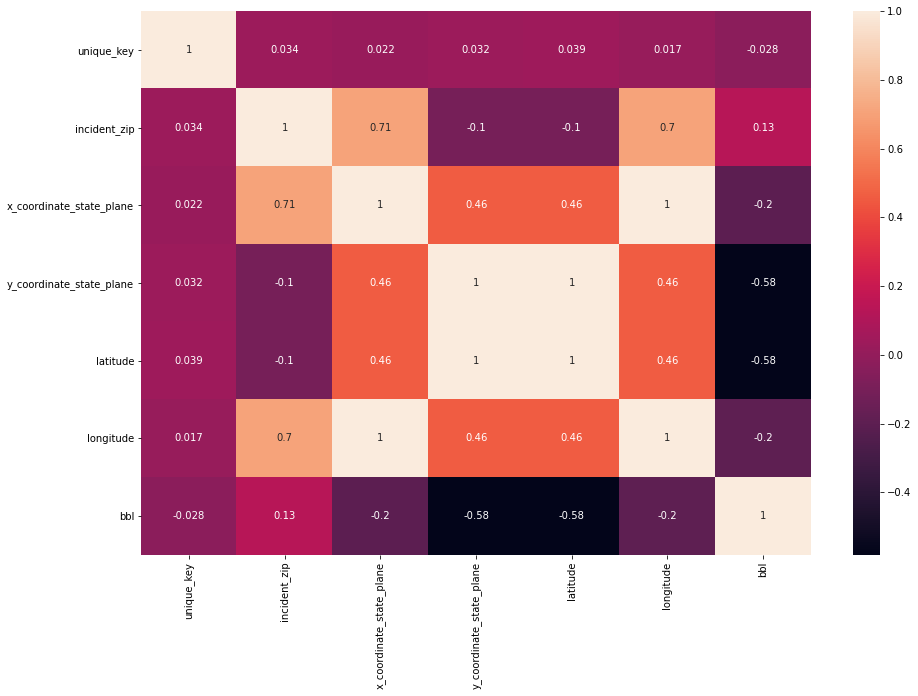

In [88]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(flooding_311.corr(), 
            annot=True, 
            ax=ax)

## 3.3 Identifying Null/NA Values

In [89]:
print('Sum of nulls in column:')
flooding_311.isna().sum().sort_values(ascending=False)

Sum of nulls in column:


intersection_street_2             17778
intersection_street_1             17778
bbl                               11735
street_name                       10033
incident_address                  10033
cross_street_2                     3765
cross_street_1                     3754
location                           3442
longitude                          3442
latitude                           3442
x_coordinate_state_plane            943
y_coordinate_state_plane            943
incident_zip                        857
city                                856
resolution_description                7
address_type                          6
closed_date                           2
park_facility_name                    0
park_borough                          0
unique_key                            0
open_data_channel_type                0
borough                               0
created_date                          0
resolution_action_updated_date        0
status                                0


In [90]:
print('Sum of nulls in all columns:')
flooding_311.isna().sum().sum()

Sum of nulls in all columns:


88816

In [91]:
print('Identifying nulls in column (True/False):')
flooding_311.isna().head()

Identifying nulls in column (True/False):


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,park_facility_name,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl
0,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,True,True,...,False,False,True,True,True,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True,True,...,False,False,True,True,True,False,False,False,False,True
3,False,False,False,False,False,False,False,False,True,True,...,False,False,True,True,True,False,False,False,False,True
4,False,False,False,False,False,False,False,False,True,True,...,False,False,True,True,True,False,False,False,False,True


In [92]:
print('Identifying any null values in column (True/False):')
flooding_311.isna().any().sort_values(ascending=False)

Identifying any null values in column (True/False):


bbl                                True
address_type                       True
x_coordinate_state_plane           True
latitude                           True
longitude                          True
resolution_description             True
location                           True
city                               True
intersection_street_2              True
intersection_street_1              True
incident_zip                       True
incident_address                   True
street_name                        True
cross_street_1                     True
cross_street_2                     True
closed_date                        True
y_coordinate_state_plane           True
park_facility_name                False
park_borough                      False
unique_key                        False
open_data_channel_type            False
borough                           False
created_date                      False
resolution_action_updated_date    False
status                            False


In [93]:
# return a boolean same-sized object indicating if any of the values are NA
flooding_311.isna().any().value_counts()

True     17
False    13
dtype: int64

In [94]:
# return descriptive statistics of boolean indicating if any of the values are NA
flooding_311.isna().any().describe()

count       30
unique       2
top       True
freq        17
dtype: object

In [95]:
# calculating a percentage of the number of nulls to total number of records of each column
missing_data = (flooding_311.isna().sum() / len(flooding_311)) * 100

# creating a dataframe
missing_data = pd.DataFrame({'Missing Ratio (%)' :missing_data}) 
missing_data.sort_values(by='Missing Ratio (%)', 
                         ascending=False, 
                         inplace=True)

missing_data.head(len(missing_data))

,Missing Ratio (%)
intersection_street_2,63.79
intersection_street_1,63.79
bbl,42.11
street_name,36.00
incident_address,36.00
cross_street_2,13.51
cross_street_1,13.47
location,12.35
longitude,12.35
latitude,12.35


In [96]:
len(flooding_311.columns)

30

In [97]:
flooding_311.iloc[:,:15].head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,address_type,city,status,resolution_description,resolution_action_updated_date
0,31862075,2015-10-28T17:44:00.000,2015-10-29T11:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11694.00,NaN,NaN,BLOCKFACE,Rockaway Park,Closed,The Department of Environmental Protection inv...,2015-10-29T11:30:00.000
1,25163797,2013-03-12T12:38:00.000,2013-03-12T14:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,NaN,NaN,BLOCKFACE,BROOKLYN,Closed,The Department of Environmental Protection ins...,2013-03-12T14:20:00.000
2,25185984,2013-03-15T12:13:00.000,2013-03-18T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,NaN,NaN,BLOCKFACE,BROOKLYN,Closed,The Department of Environmental Protection ins...,2013-03-18T14:15:00.000
3,25187738,2013-03-15T12:20:00.000,2013-03-15T14:22:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,NaN,NaN,BLOCKFACE,BROOKLYN,Closed,The Department of Environmental Protection has...,2013-03-15T14:22:00.000
4,25338491,2013-04-11T12:16:00.000,2013-04-11T12:16:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.00,NaN,NaN,BLOCKFACE,BROOKLYN,Closed,The Department of Environmental Protection has...,2013-04-11T12:16:00.000


In [98]:
flooding_311.iloc[:,15:30].head()

,community_board,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl
0,14 QUEENS,QUEENS,1033547.00,152391.00,PHONE,Unspecified,QUEENS,40.58,-73.82,"{'latitude': '40.5848189', 'longitude': '-73.8...",BEACH 101 STREET,BEACH 101 STREET,ROCKAWAY FREEWAY,BEACH CHANNEL DRIVE,NaN
1,Unspecified BROOKLYN,BROOKLYN,1010685.00,171510.00,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN
2,Unspecified BROOKLYN,BROOKLYN,1010685.00,171510.00,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN
3,Unspecified BROOKLYN,BROOKLYN,1010685.00,171510.00,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN
4,Unspecified BROOKLYN,BROOKLYN,1010685.00,171510.00,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,CHURCH LANE,CHURCH LANE,EAST 89 STREET,EAST 88 STREET,NaN
